<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/nlp/universal-sentence-encoder/use_sentence_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universal Sentence Encoder - Semantic Similarity

Sentence embedding encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other nlp tasks. The input is a variable lenght multi-lingual text(depending on the model selected) and the output is a 512 dimensional vector.

Goals:

[✓] Compute semantic similarity (dot-product & cosine).<br>
[  ] Encode multi-lingual text.<br>
[✓] Evaludate results againts [STS](http://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark) benchmark.<br> 
[✓] Visualize sentence similarity.<br>


In [1]:
#@title Setup
#@markdown - Install seaborn
#@markdown - Import packages

!pip install -Uqq seaborn

import csv
import math
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from absl import logging

print("tensorflow     ", tf.__version__)
print("tensorflow-hub ", hub.__version__)

tensorflow      2.4.0
tensorflow-hub  0.11.0


In [2]:
#@title Select USE model
use_model ="universal-sentence-encoder-large [en]" #@param ["universal-sentence-encoder [en]", "universal-sentence-encoder-large [en]"]

if use_model == "universal-sentence-encoder [en]":
    model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
else:
    model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

print("Loading model", model_url)
model = hub.load(model_url)
print("Model signatures", model.signatures)

Loading model https://tfhub.dev/google/universal-sentence-encoder-large/5
Model signatures _SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(inputs) at 0x7EFBEA58C668>})


## 1. Compute a representation for each message, showing various lengths supported

In [3]:
def embed(input, as_numpy=False):
    input_embeddings = model(input)
    if as_numpy:
        input_embeddings = np.array(input_embeddings).tolist()
    return input_embeddings

In [4]:
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be."
)
messages = [word, sentence, paragraph]

logging.set_verbosity(logging.ERROR)
message_embeddings = embed(messages, as_numpy=True)

for i, message_embeddings in enumerate(message_embeddings):
    print("Message:       ", messages[i])
    print("Embedding size:", len(message_embeddings))
    message_embedding_snippet = ", ".join((str(x) for x in message_embeddings[:3]))
    print("Embedding:     ", message_embedding_snippet, "...")
    print()

Message:        Elephant
Embedding size: 512
Embedding:      -0.0345856137573719, -0.01799011044204235, 0.0019805801566690207 ...

Message:        I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding:      0.05833393335342407, -0.08185011148452759, 0.0689094066619873 ...

Message:        Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding:      -0.026461763307452202, -0.019115637987852097, -0.042070381343364716 ...



## 2. Plot Semantic similarity

The embeddings produces by the Universal Sentence Encoder are approciamatelly normalized. The semantic similarity of two sentences can be computed as the inner product of the encoddings.

In [5]:
def plot_similarity(labels, corr, rotation=90):
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd",
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic textual similarity")

In [6]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

message_embeddings = embed(messages)

### 2.1 Dot-product similarity

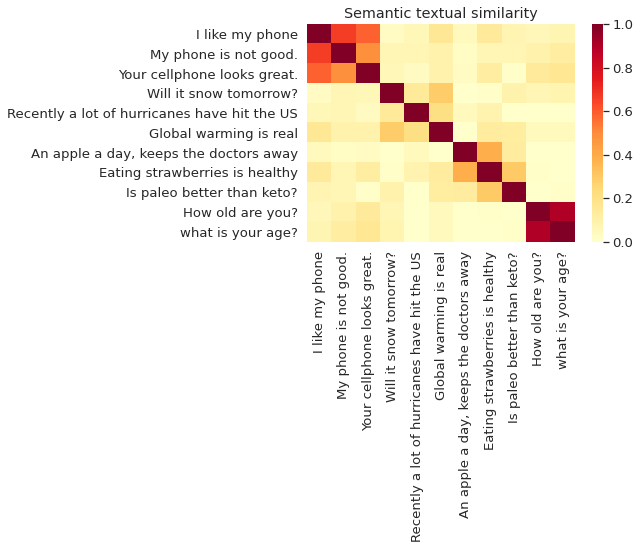

In [7]:
dot_product_similarity = np.inner(message_embeddings, message_embeddings)
plot_similarity(messages, dot_product_similarity)

### 2.2 Cosine similarity

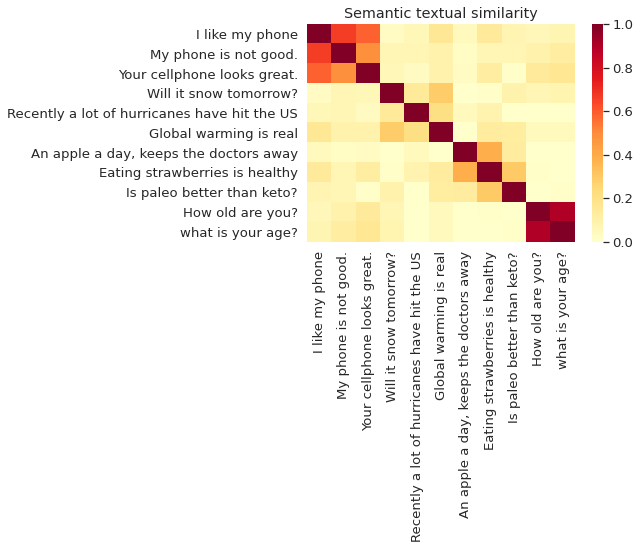

In [8]:
n = len(message_embeddings)
mag = lambda embed: np.sqrt(np.dot(embed, embed))
cosine = lambda embed_i, embed_j: np.dot(embed_i, embed_j) / (
    mag(embed_i) * mag(embed_j)
)
cosine_similarity = [
    cosine(message_embeddings[i], message_embeddings[j])
    for i in range(n)
    for j in range(n)
]
cosine_similarity = np.array(cosine_similarity).reshape(n, n)
plot_similarity(messages, cosine_similarity)

## 3. Evaluate STS benchmark
The Semantic Textual Simililarity(STS) benchmark provides an intrinsic evaluation of the degree to which similarity scores are computed using sentence embeddings aligned with human judgement. The benchmark requires systems to return scores for a diverse selection of sentence pairs. Pearson correlation is then used to evaluate the quality of the machine similarity against human judgment.

In [9]:
dataset_url = "http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz"
sts_dataset = tf.keras.utils.get_file(fname="Stsbenchmark.tar.gz", origin=dataset_url, extract=True)
path_to_datasets = os.path.join(os.path.dirname(sts_dataset), "stsbenchmark")
path_to_dev_dataset = os.path.join(path_to_datasets, "sts-dev.csv")
path_to_test_dataset = os.path.join(path_to_datasets, "sts-test.csv")

print()
print("dev dataset  ", path_to_dev_dataset)
print("test dataset ", path_to_test_dataset)


dev dataset   /root/.keras/datasets/stsbenchmark/sts-dev.csv
test dataset  /root/.keras/datasets/stsbenchmark/sts-test.csv


In [10]:
sts_dev = pd.read_table(
    path_to_dev_dataset, 
    error_bad_lines=False, 
    skip_blank_lines=True, 
    usecols=[4,5,6], 
    names=["sim", "sent_1", "sent_2"]
)

sts_test = pd.read_table(
    path_to_test_dataset, 
    error_bad_lines=False, 
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True, 
    usecols=[4,5,6], 
    names=["sim", "sent_1", "sent_2"]
)

sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev["sent_2"]]]
sts_dev

,sim,sent_1,sent_2
0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
1,4.75,A young child is riding a horse.,A child is riding a horse.
2,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
3,2.40,A woman is playing the guitar.,A man is playing guitar.
4,2.75,A woman is playing the flute.,A man is playing a flute.
...,...,...,...
1465,2.00,Scientists prove there is water on Mars,Has Nasa discovered water on Mars?
1466,0.00,Pranab stresses need to strive for peace by na...,WTO: India regrets action of developed nations
1467,2.00,Volkswagen skids into red in wake of pollution...,"Volkswagen's ""gesture of goodwill"" to diesel o..."
1468,0.00,Obama is right: Africa deserves better leadership,Obama waiting for midterm to name attorney gen...


In [11]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

def run_sts_benchmark(batch):
    embed_1 = embed(batch["sent_1"].tolist())
    embed_2 = embed(batch["sent_2"].tolist())
    sts_encode_1 = tf.nn.l2_normalize(embed_1, axis=1)
    sts_encode_2 = tf.nn.l2_normalize(embed_2, axis=1)
    cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode_1, sts_encode_2), axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
    return scores

dev_scores = sts_data["sim"].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
    scores.extend(run_sts_benchmark(batch))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print(f"Pearson correlation coefficient = {pearson_correlation[0]}")
print(f"np-value = {pearson_correlation[1]}")

Pearson correlation coefficient = 0.8334395880354448
np-value = 0.0
